In [ ]:
import os
import numpy as np
import proplot as plot

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

from utils.logger import Logger
import models.model_loader as ml

In [ ]:
params_file = os.path.expanduser("~")+"/Work/Projects/mlp_mnist/logfiles/mlp_mnist_v0.0.log"
logger = Logger(params_file, overwrite=False)

log_text = logger.load_file()
params = logger.read_params(log_text)[-1]

In [ ]:
model = ml.load_model(params.model_type)
model.setup(params, logger)
model.to(params.device)
model.load_state_dict(torch.load(model.params.cp_save_dir+"trained_model.pt"))

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../Datasets/', train=False, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0,), std=(255,)), # rescale to be 0 to 1
    transforms.Lambda(lambda x: x.permute(1, 2, 0))])), # channels last
    batch_size=params.batch_size, shuffle=True, num_workers=0, pin_memory=False)

In [ ]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(params.device), target.to(params.device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction="sum").item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy, "%")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re

def plot_stats(data, keys=None, labels=None, start_index=0, figsize=None, save_filename=None):
    """
    Generate time-series plots of stats specified by keys
    Inputs:
        data: [dict] containing data to be plotted. len of all values should be equal
            data must have the key "batch_step"
        keys: [list of str] optional list of keys to plot, each should exist in data.keys()
            If nothing is given, data.keys() will be used
        labels: [list of str] optional list of labels, should be the same length as keys input
            If nothing is given, data.keys() will be used
        save_filename: [str] containing the complete output filename.
    """
    if keys is None:
        keys = list(data.keys())
    else:
        assert all([key in data.keys() for key in keys]), (
            "All input keys must exist as keys in the data dictionary")
    assert len(keys) > 0, "Keys must be None or have length > 0."
    if "batch_step" in keys:
        keys.remove("batch_step")
    if "schedule_index" in keys:
        keys.remove("schedule_index")
    if "global_batch_index" in keys:
        keys.remove("global_batch_index")
    if labels is None:
        labels = keys
    else:
        assert len(labels) == len(keys), (
            "The number of labels must match the number of keys")
    num_keys = len(keys)
    gs = gridspec.GridSpec(num_keys, 1, hspace=0.5)
    fig = plt.figure(figsize=figsize)
    axis_image = [None]*num_keys
    for key_idx, key in enumerate(keys):
        x_dat = data["batch_step"][start_index:]
        y_dat = data[key][start_index:]
        ax = fig.add_subplot(gs[key_idx])
        axis_image[key_idx] = ax.plot(x_dat, y_dat)
        if key_idx < len(keys)-1:
            ax.get_xaxis().set_ticklabels([])
        ax.locator_params(axis="y", nbins=5)
        ax.set_ylabel("\n".join(re.split("_", labels[key_idx])))
        ax.set_yticks([np.minimum(0.0, np.min(y_dat)), np.maximum(0.0, np.max(y_dat))])
        ylabel_xpos = -0.05
        ax.yaxis.set_label_coords(ylabel_xpos, 0.5)
    ax.set_xlabel("Batch Number")
    fig.suptitle("Stats per Batch", y=0.95, x=0.5)
    if save_filename is not None:
        fig.savefig(save_filename, transparent=True)
        plt.close(fig)
        return None
    plt.show()
    return fig

In [ ]:
run_stats = logger.read_stats(log_text)

In [ ]:
keys=["loss", "train_accuracy"]
labels=["Loss", "Train Accuracy"]
stats_fig = plot_stats(run_stats, keys=keys, labels=labels, start_index=0, figsize=(10,5))

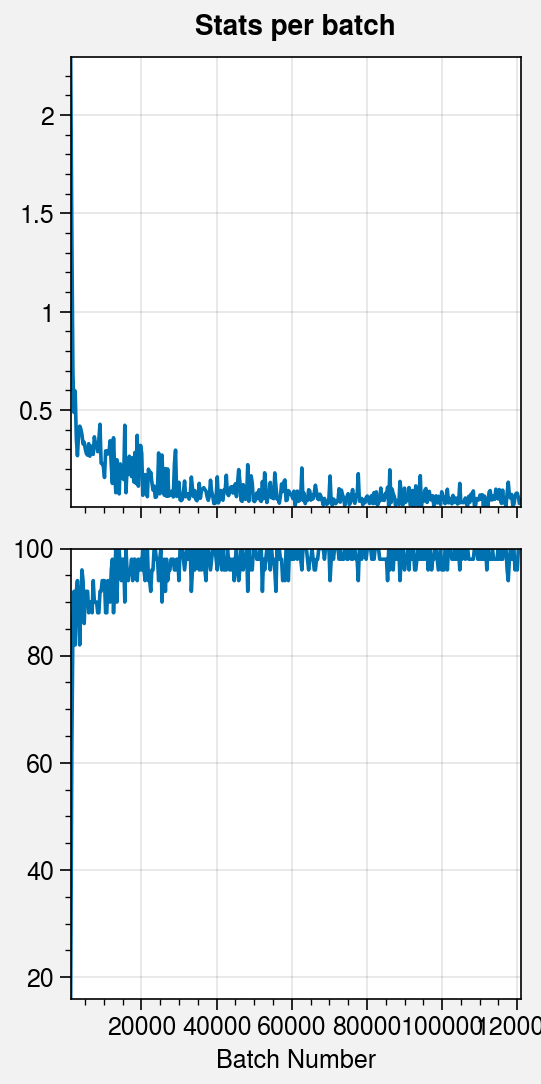

In [27]:
keys=["loss", "train_accuracy"]
labels=["Loss", "Train Accuracy"]
stats_fig = plot_stats2(run_stats, keys=keys, labels=labels, start_index=0)